# Red Neuronal Convolucional

# Sección 1: Configuración Inicial y Preparación de Datos

## 1.Importación de Librerías

In [21]:
# 1. IMPORTS

import numpy as np
import pandas as pd
import time
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection     import train_test_split
from sklearn.impute              import SimpleImputer
from sklearn.preprocessing       import StandardScaler, OneHotEncoder
from sklearn.compose             import ColumnTransformer
from sklearn.pipeline            import Pipeline
from sklearn.metrics             import (
    precision_score, recall_score, f1_score,
    roc_auc_score, accuracy_score, confusion_matrix,
    precision_recall_curve, average_precision_score,
    roc_curve
)
from sklearn.calibration         import calibration_curve
from sklearn.metrics             import ConfusionMatrixDisplay
from scipy.stats                 import ks_2samp

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import (
    Input, Conv1D, BatchNormalization, Dropout,
    Flatten, Dense
)
from tensorflow.keras.callbacks  import EarlyStopping


## 2.Carga y División de Datos

In [22]:
# 2. CARGA DE DATOS

df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")

y = df["incumplimiento_credito"]
X = df.drop(columns=["incumplimiento_credito"])

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 3.Preprocesamiento de Datos

In [23]:
# 3. PREPROCESAMIENTO
num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

num_tf = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("sc",  StandardScaler())
])
cat_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols),
])

X_train_scaled = preprocessor.fit_transform(X_train_raw)
X_test_scaled  = preprocessor.transform(X_test_raw)



In [24]:
# 4. Formatear para Conv1D → tratamos cada feature como "time step"
#    Shape: (n_samples, n_timesteps, 1_channel)
n_feats = X_train_scaled.shape[1]
X_train_seq = X_train_scaled.reshape(-1, n_feats, 1)
X_test_seq  = X_test_scaled.reshape(-1, n_feats, 1)

# Sección 2: Definición de la Arquitectura CNN y GridSearch

## 1.Definición de la Arquitectura CNN

In [25]:
# 5. función de fábrica de modelos CNN
def create_cnn_model(filters=32, kernel_size=3, dropout_rate=0.2):
    inp = Input(shape=(n_feats, 1))
    x   = Conv1D(filters=filters,
                 kernel_size=kernel_size,
                 padding="same",
                 activation="relu")(inp)
    x   = BatchNormalization()(x)
    x   = Dropout(dropout_rate)(x)
    x   = Flatten()(x)
    x   = Dense(64, activation="relu")(x)
    x   = Dropout(dropout_rate)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inp, out, name="cnn_classifier")
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


## 2.GridSearch de Hiperparámetros

In [26]:
# 6. Grid de hiperparámetros
from sklearn.model_selection import ParameterGrid

param_grid = {
    "filters":     [32, 64],
    "kernel_size": [3, 5],
    "dropout_rate":[0.2, 0.3],
    "batch_size":  [32, 64],
    "epochs":      [30, 50]
}

grid = list(ParameterGrid(param_grid))
results = []

for i, params in enumerate(grid, 1):
    print(f"🔍 {i}/{len(grid)} • {params}")
    tf.keras.backend.clear_session()
    cnn = create_cnn_model(
        filters=params["filters"],
        kernel_size=params["kernel_size"],
        dropout_rate=params["dropout_rate"]
    )
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    t0 = time.time()
    hist = cnn.fit(
        X_train_seq, y_train,
        validation_split=0.2,
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=[es],
        verbose=0
    )
    fit_time = (time.time() - t0) / 60  # minutos

    # predicciones
    y_proba = cnn.predict(X_test_seq).ravel()
    y_pred  = (y_proba >= 0.5).astype(int)

    # métricas
    metrics = {
        **params,
        "accuracy":    accuracy_score(y_test, y_pred),
        "precision":   precision_score(y_test, y_pred, zero_division=0),
        "recall":      recall_score(y_test, y_pred, zero_division=0),
        "f1":          f1_score(y_test, y_pred, zero_division=0),
        "auc":         roc_auc_score(y_test, y_proba),
        "ap":          average_precision_score(y_test, y_proba),
        "fit_minutes": round(fit_time, 2),
        "history":     hist.history,
        "y_proba":     y_proba,
        "y_pred":      y_pred,
        "model":       cnn
    }
    results.append(metrics)


🔍 1/32 • {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'filters': 32, 'kernel_size': 3}
491/491 [==============================] - 0s 917us/step
🔍 2/32 • {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'filters': 32, 'kernel_size': 5}
491/491 [==============================] - 0s 749us/step
🔍 3/32 • {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'filters': 64, 'kernel_size': 3}
491/491 [==============================] - 1s 2ms/step
🔍 4/32 • {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'filters': 64, 'kernel_size': 5}
491/491 [==============================] - 1s 2ms/step
🔍 5/32 • {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'filters': 32, 'kernel_size': 3}
491/491 [==============================] - 0s 839us/step
🔍 6/32 • {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'filters': 32, 'kernel_size': 5}
491/491 [==============================] - 0s 869us/step
🔍 7/32 • {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'filters': 64, 'kernel_

In [27]:
# 7. DataFrame resumen y mejor combinación por recall
df_res = pd.DataFrame(results)
df_res = df_res.sort_values("recall", ascending=False).reset_index(drop=True)

# Mostrar top 5 configuraciones
df_viz = df_res[[
    "filters","kernel_size","dropout_rate","batch_size","epochs",
    "accuracy","precision","recall","f1","auc","ap","fit_minutes"
]].round({
    "accuracy":4,"precision":4,"recall":4,"f1":4,"auc":4,"ap":4
})
display(
    df_viz.head(5).style
        .set_caption("Top 5 Configuraciones CNN")
        .background_gradient(subset=["recall","auc"], cmap="Blues")
        .highlight_max("recall", color="salmon")
)
best = df_res.iloc[0]
print(f"➡️ Mejor modelo CNN por Recall: filters={best.filters}, ks={best.kernel_size}, dr={best.dropout_rate}")


,filters,kernel_size,dropout_rate,batch_size,epochs,accuracy,precision,recall,f1,auc,ap,fit_minutes
0,64,5,0.200000,32,30,0.914500,0.444400,0.003000,0.005900,0.744200,0.226600,2.330000
1,32,5,0.300000,64,30,0.914500,0.428600,0.002200,0.004500,0.740700,0.231700,0.580000
2,32,3,0.300000,64,30,0.914700,0.750000,0.002200,0.004500,0.743200,0.234700,0.790000
3,32,3,0.200000,32,50,0.914600,1.000000,0.000700,0.001500,0.743800,0.233500,1.240000
4,32,5,0.300000,64,50,0.914500,0.500000,0.000700,0.001500,0.742800,0.236000,0.940000


➡️ Mejor modelo CNN por Recall: filters=64, ks=5, dr=0.2


In [28]:
cnn_best   = best["model"]
hist_best  = best["history"]
y_proba_b  = best["y_proba"]
y_pred_b   = best["y_pred"]
fit_min    = best["fit_minutes"]

# Sección 3: Evaluación Básica del Modelo

## 1.Curva de Entrenamiento (Loss Curve)


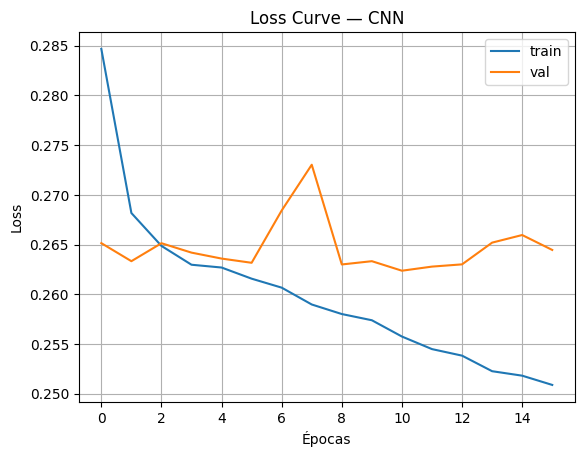

In [29]:
# 3.1 Curva de pérdida
plt.plot(hist_best["loss"], label="train")
plt.plot(hist_best["val_loss"], label="val")
plt.title("Loss Curve — CNN")
plt.xlabel("Épocas"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()



## 2.Tabla de Hiperparámetros Óptimos


In [30]:
# 1️⃣ Asegúrate de tener tu DataFrame de resultados ordenado por recall:
df_res = pd.DataFrame(results)
df_res = df_res.sort_values("recall", ascending=False).reset_index(drop=True)

# 2️⃣ Extrae la mejor configuración (primera fila)
mejor = df_res.iloc[0]

# 3️⃣ Construye la tabla de hiperparámetros óptimos
df_hiperopt = pd.DataFrame([{
    "Filtros (Conv1D)": mejor["filters"],
    "Kernel Size":      mejor["kernel_size"],
    "Dropout Rate":     mejor["dropout_rate"],
    "Batch Size":       mejor["batch_size"],
    "Épocas":           mejor["epochs"],
    "Recall":           mejor["recall"],
    "AUC":              mejor["auc"],
    "Fit Time (min)":   mejor["fit_minutes"]
}])

# 4️⃣ Muestra con estilo
display(
    df_hiperopt.style
        .format({
            "Dropout Rate":   "{:.2f}",
            "Recall":         "{:.4f}",
            "AUC":            "{:.4f}",
            "Fit Time (min)": "{:.2f}"
        })
        .set_caption("Hiperparámetros Óptimos — CNN")
        .background_gradient(subset=["Recall","AUC"], cmap="Blues")
)


,Filtros (Conv1D),Kernel Size,Dropout Rate,Batch Size,Épocas,Recall,AUC,Fit Time (min)
0,64,5,0.20,32,30,0.0030,0.7442,2.33


## 3.Métricas de Desempeño del Modelo

In [31]:
# Seleccionar el diccionario con el mejor AUC
mejor_resultado = max(results, key=lambda x: x["auc"])

# Crear el DataFrame a partir del mejor resultado
df_metrics = pd.DataFrame([{
    "Accuracy":  mejor_resultado["accuracy"],
    "Precision": mejor_resultado["precision"],
    "Recall":    mejor_resultado["recall"],
    "F1-Score":  mejor_resultado["f1"],
    "AUC":       mejor_resultado["auc"],
    "AP":        mejor_resultado["ap"],
    "Tiempo (min)": mejor_resultado["fit_minutes"]
}], index=["CNN"])

display(
    df_metrics.style
        .format("{:.4f}")
        .set_caption("📊 Métricas Finales — Mejor CNN")
        .background_gradient(subset=["Recall", "AUC"], cmap="Purples")
)

,Accuracy,Precision,Recall,F1-Score,AUC,AP,Tiempo (min)
CNN,0.9143,0.0000,0.0000,0.0000,0.7464,0.2305,0.5900


## 4.Matriz de Confusión sin Técnicas de Balanceo

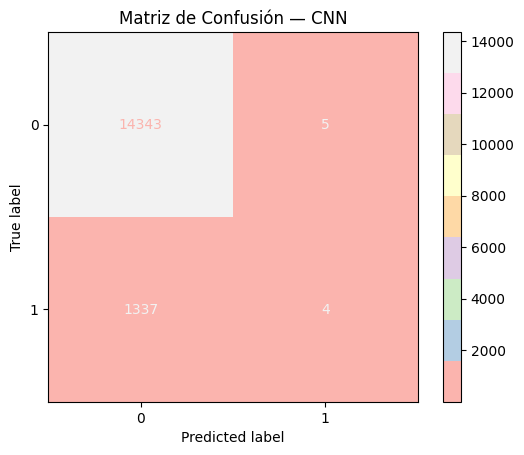

In [32]:
# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_b)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Pastel1")
plt.title("Matriz de Confusión — CNN"); plt.show()

## 5.Curva ROC

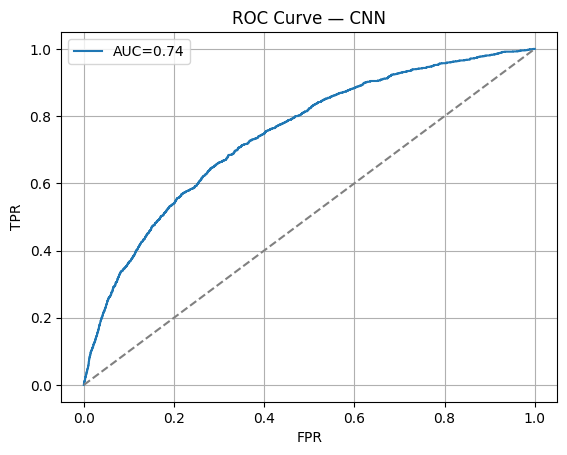

In [33]:
# 3.3 Curva ROC & AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_b)
auc_score   = roc_auc_score(y_test, y_proba_b)
plt.plot(fpr, tpr, label=f"AUC={auc_score:.2f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curve — CNN")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.grid(True); plt.show()


## 6.Curva Precision–Recall

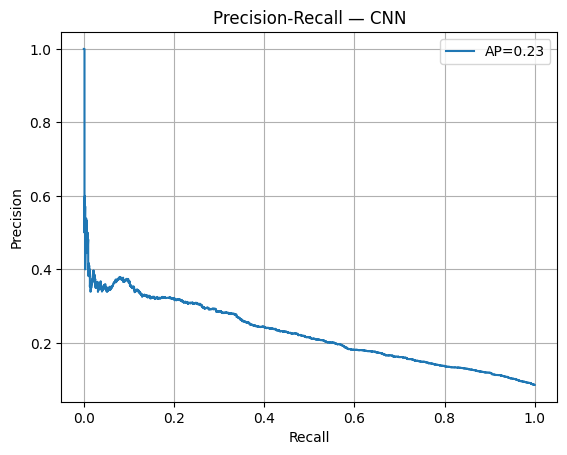

In [34]:
# 3.4 Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_proba_b)
ap_score     = average_precision_score(y_test, y_proba_b)
plt.plot(rec, prec, label=f"AP={ap_score:.2f}")
plt.title("Precision-Recall — CNN")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.grid(True); plt.show()


## 7.Curva KS (Kolmogorov–Smirnov)

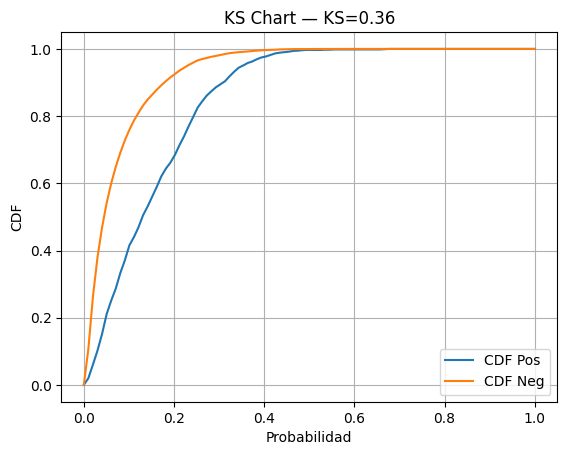

In [35]:
# 3.5 KS Chart
pos = y_proba_b[y_test==1]
neg = y_proba_b[y_test==0]
ks_stat, _ = ks_2samp(pos, neg)
x = np.linspace(0,1,100)
cdf_pos = [np.mean(pos<=xi) for xi in x]
cdf_neg = [np.mean(neg<=xi) for xi in x]
plt.plot(x, cdf_pos, label="CDF Pos")
plt.plot(x, cdf_neg, label="CDF Neg")
plt.title(f"KS Chart — KS={ks_stat:.2f}")
plt.xlabel("Probabilidad"); plt.ylabel("CDF")
plt.legend(); plt.grid(True); plt.show()


# Sección 4: Evaluación Avanzada del Modelo

## 1.Curva de Ganancias Acumuladas / Lift Chart

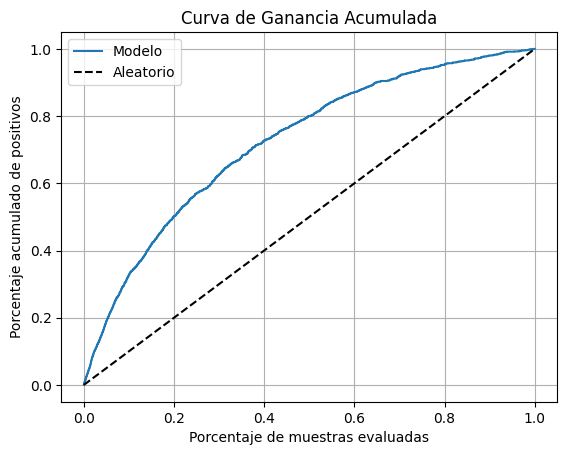

In [36]:
import numpy as np

def plot_cumulative_gain(y_true, y_proba):
    sorted_indices = np.argsort(y_proba)[::-1]
    y_sorted = np.array(y_true)[sorted_indices]
    cumulative_gain = np.cumsum(y_sorted) / sum(y_sorted)
    percentage_samples = np.arange(1, len(y_sorted) + 1) / len(y_sorted)

    plt.plot(percentage_samples, cumulative_gain, label="Modelo")
    plt.plot([0, 1], [0, 1], 'k--', label="Aleatorio")
    plt.xlabel("Porcentaje de muestras evaluadas")
    plt.ylabel("Porcentaje acumulado de positivos")
    plt.title("Curva de Ganancia Acumulada")
    plt.legend()
    plt.grid()
    plt.show()

plot_cumulative_gain(y_test, y_proba_b)


## 2.Radar Plot de métricas por técnica

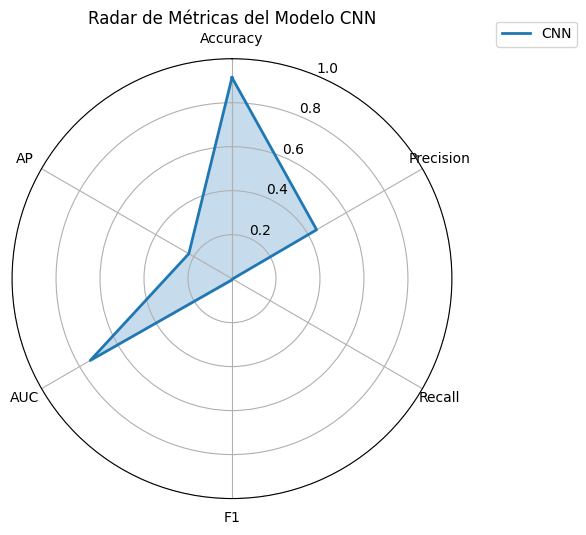

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas del modelo
metrics_cnn = {
    "Accuracy": accuracy_score(y_test, y_pred_b),
    "Precision": precision_score(y_test, y_pred_b, zero_division=0),
    "Recall": recall_score(y_test, y_pred_b, zero_division=0),
    "F1": f1_score(y_test, y_pred_b, zero_division=0),
    "AUC": roc_auc_score(y_test, y_proba_b),
    "AP": average_precision_score(y_test, y_proba_b)
}

# Convertir a valores para radar
labels = list(metrics_cnn.keys())
values = list(metrics_cnn.values())
values += values[:1]  # cerrar la figura circularmente

# Ángulos para cada eje
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=2, linestyle='solid', label="CNN")
ax.fill(angles, values, alpha=0.25)

# Personalización
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Radar de Métricas del Modelo CNN")
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.grid(True)
plt.tight_layout()
plt.show()


## 3.Curva de Calibración (Reliability Curve)

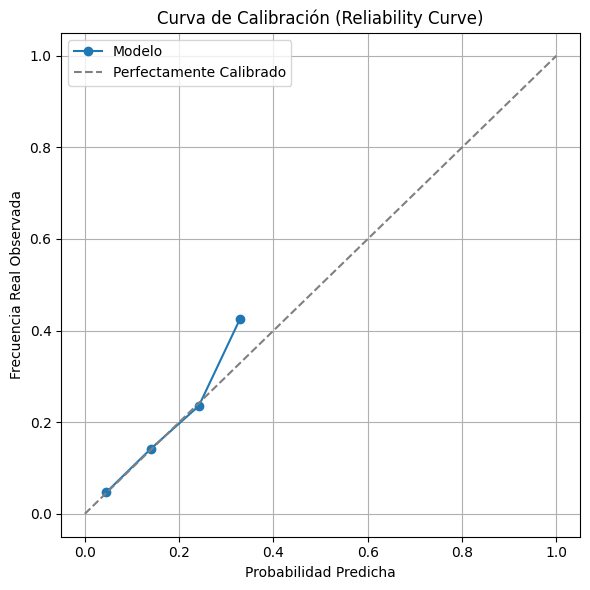

In [38]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# y_test: verdaderas etiquetas
# y_proba: probabilidades predichas por el modelo para la clase positiva (1)

# Calcular la curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')

# Graficar la curva de calibración
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Modelo')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectamente Calibrado', color='gray')
plt.xlabel("Probabilidad Predicha")
plt.ylabel("Frecuencia Real Observada")
plt.title("Curva de Calibración (Reliability Curve)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Sección 5: Guardar Resultados

In [ ]:
import os
print("📌 Directorio actual:", os.getcwd())

📌 Directorio actual: c:\Users\DELL\Desktop\Aprendizaje_de_Maquina\jbook_Proyecto_Final_Clasificacion\Template_Jupyter_Book
